In [1]:
PATH = 'D:\\OneDrive - National University of Singapore\\industry-classification-master\\data\\'

In [37]:
import keras
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling, lecun_normal,glorot_uniform
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from clustering_class import *
from new_combine_models import *
from DEC import *
from generate_word_vector import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
des = pd.read_csv(PATH+'Russell3000_intro.csv')
#des.columns = ['company','des']
des.head()

,Unnamed: 0,company,intro,segment,industry,introLen,lemma,intro_lemmatized
0,0,MMM,"3M Company develops, manufactures, and markets...",Industrials,Specialty Industrial Machinery,1581,"['3m', 'company', 'develop', 'manufacture', 'a...",3m company develop manufacture and market vari...
1,1,ABT,"Abbott Laboratories discovers, develops, manuf...",Healthcare,Medical Devices,1954,"['abbott', 'laboratories', 'discover', 'develo...",abbott laboratories discover develop manufactu...
2,2,ABBV,"AbbVie Inc., a research-based biopharmaceutica...",Healthcare,Drug Manufacturers—General,1997,"['abbvie', 'inc', 'a', 'research', 'base', 'bi...",abbvie inc a research base biopharmaceutical c...
3,3,ABMD,"Abiomed, Inc. engages in the research, develop...",Healthcare,Medical Devices,1182,"['abiomed', 'inc', 'engage', 'in', 'the', 'res...",abiomed inc engage in the research development...
4,4,ACN,"Accenture plc provides consulting, technology,...",Technology,Information Technology Services,1989,"['accenture', 'plc', 'provide', 'consult', 'te...",accenture plc provide consult technology and o...


In [16]:
all_data['paper'].shape

(2896, 4177)

In [5]:
all_data = {}
company_list=des['company'].values
desc_list=des['intro'].values
stopwords = stopwords.words('english')+[' ']
vector_generator=generate_doc_vector(company_list,desc_list,stopwords,0.8,5,'English')
bag_of_words=vector_generator.bag_of_words()
all_data['bag of words']=bag_of_words

In [6]:
for i in range(50,401,50):
    doc2vec_1=vector_generator.doc2vector(vector_size=i,alpha=0.01)
    doc2vec_2=vector_generator.doc2vector(vector_size=i,alpha=0.01,dm=0)
    all_data['pvdm %d length'%i]=doc2vec_1
    all_data['pvdbow %d length'%i]=doc2vec_2
for i in range(200,1101,100):
    Lsi=vector_generator.LSI(num_topics=i)
    all_data['lsi %d length'%i]=Lsi

In [7]:
bert = pd.read_excel(PATH+'bert_Russell3000.xlsx')
vec = list(map(eval,bert['bert_vec'].values.tolist()))
bert = pd.concat([bert[['company']],pd.DataFrame(vec)],axis=1)
all_data['bert'] = bert

In [8]:
all_data.keys()

dict_keys(['bag of words', 'pvdm 50 length', 'pvdbow 50 length', 'pvdm 100 length', 'pvdbow 100 length', 'pvdm 150 length', 'pvdbow 150 length', 'pvdm 200 length', 'pvdbow 200 length', 'pvdm 250 length', 'pvdbow 250 length', 'pvdm 300 length', 'pvdbow 300 length', 'pvdm 350 length', 'pvdbow 350 length', 'pvdm 400 length', 'pvdbow 400 length', 'lsi 200 length', 'lsi 300 length', 'lsi 400 length', 'lsi 500 length', 'lsi 600 length', 'lsi 700 length', 'lsi 800 length', 'lsi 900 length', 'lsi 1000 length', 'lsi 1100 length', 'bert'])

In [9]:
classes = pd.read_csv(PATH+'SIC_NAICS_us.csv',header=None)
classes = classes[[0,3,4]]
classes.columns = ['company','SIC','NAICS']
classes = classes[classes['company'].astype(str).isin(company_list)]

In [10]:
GICS = pd.read_csv(PATH+'GICS_us.csv',header=None)
GICS['GICS'] = GICS[1].apply(lambda x: str(x)[:6])
GICS.columns=['company','code','GICS']
classes = classes.merge(GICS[['company','GICS']],on=['company'],how='inner')

In [11]:
classes.head()

,company,SIC,NAICS,GICS
0,A,38,33,352030
1,AA,33,33,151040
2,AAL,45,48,203020
3,AAN,57,53,255040
4,AAOI,36,33,452010


In [12]:
print('%d companys'%len(classes['company'].unique()))
print('%d SIC code'%len(classes['SIC'].unique()))
print('%d NAICS code'%len(classes['NAICS'].unique()))
print('%d GICS code'%len(classes['GICS'].unique()))

2852 companys
65 SIC code
24 NAICS code
69 GICS code


In [50]:
tf.__version__

'2.2.0'

In [33]:
def lr_sch(epoch):
    return 1/(epoch+1)

In [34]:
target_classes = 'GICS'
tol = 0.01
maxiter = 1000
update_interval = 100
n_clusters = len(classes[target_classes].unique())
n_epochs=100
batch_size_auto=128
batch_size=128
init = glorot_uniform()
pretrain_optimizer = SGD(lr=1, momentum=0.9)
optimizer=SGD(lr=0.01,momentum=0.9,decay=0.01/n_epochs)
lr_scheduler=keras.callbacks.LearningRateScheduler(lr_sch, verbose=0)
early_stopping= keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0002, patience=5)
logdir="logs/fit/USBert" 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
output=[]
kmeans = KMeans(n_clusters=n_clusters)

In [53]:
for key,input in all_data.items():
    input_x=input.iloc[:,1:]
    dims=[input_x.shape[-1],500,200,2000,50]
    autoencode, encoder = autoencoder(dims, act='relu', init=init, dropout=0.2)
    autoencode.compile(optimizer=pretrain_optimizer, loss='mse')
    autoencode.fit(input_x, input_x, batch_size=batch_size, epochs=n_epochs,callbacks=[lr_scheduler,early_stopping])
    kmeans=kmeans.fit(encoder.predict(input_x))
    y_init=kmeans.cluster_centers_
    loss = 0
    index = 0
    index_array = np.arange(input_x.shape[0])
    clustering_layer = ClusteringLayer(n_clusters=n_clusters, name='clustering',weights=[y_init])(encoder.output)
    model = Model(inputs=encoder.input, outputs=clustering_layer)    
    model.compile(loss='kld', optimizer=optimizer)
    y_pred_last=kmeans.predict(encoder.predict(input_x))
    for ite in range(maxiter):
        if ite % update_interval == 0:
            q = model.predict(input_x, verbose=0)
            p = target_distribution(q)  # update the auxiliary target distribution p

            # evaluate the clustering performance
            y_pred = q.argmax(1)

            # check stop criterion
            delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
            y_pred_last = np.copy(y_pred)
            print('the '+str(ite)+'th training on '+key)
            if ite > 0 and delta_label < tol:
                print('delta_label = ', delta_label, ' < %d'%tol)
                print('Reached tolerance threshold. Stopping training.')
                break
        idx = index_array[index * batch_size: min((index+1) * batch_size, input_x.shape[0])]
        loss = model.train_on_batch(x=input_x.iloc[idx], y=p[idx])
        index = index + 1 if (index + 1) * batch_size <= input_x.shape[0] else 0
    q = model.predict(input_x,verbose=0)
    clas=pd.DataFrame(np.argmax(q,1),columns=[key])
    clas.insert(0,'company',input['company'])
    output.append(clas)

Epoch 1/100
2896/2896 [==============================] - 2s 664us/step - loss: 0.0339
Epoch 2/100
 896/2896 [========>.....................] - ETA: 0s - loss: 0.0202

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 159us/step - loss: 0.0168
Epoch 3/100
2896/2896 [==============================] - 0s 159us/step - loss: 0.0106
Epoch 4/100
2896/2896 [==============================] - 0s 159us/step - loss: 0.0082
Epoch 5/100
2896/2896 [==============================] - 0s 157us/step - loss: 0.0070
Epoch 6/100
2896/2896 [==============================] - 0s 158us/step - loss: 0.0061
Epoch 7/100
2896/2896 [==============================] - 0s 161us/step - loss: 0.0056
Epoch 8/100
2896/2896 [==============================] - 0s 165us/step - loss: 0.0051
Epoch 9/100
2896/2896 [==============================] - 0s 162us/step - loss: 0.0048
Epoch 10/100
2896/2896 [==============================] - 0s 156us/step - loss: 0.0045
Epoch 11/100
2896/2896 [==============================] - 0s 157us/step - loss: 0.0042
Epoch 12/100
2896/2896 [==============================] - 0s 161us/step - loss: 0.0041
Epoch 13/100
2896/2896 [==============================] - 0s 16

Epoch 96/100
2896/2896 [==============================] - 0s 161us/step - loss: 0.0016
Epoch 97/100
2896/2896 [==============================] - 0s 164us/step - loss: 0.0015
Epoch 98/100
2896/2896 [==============================] - 0s 168us/step - loss: 0.0015
Epoch 99/100
2896/2896 [==============================] - 0s 169us/step - loss: 0.0015
Epoch 100/100
2896/2896 [==============================] - 0s 163us/step - loss: 0.0016
the 0th training on bag of words
the 100th training on bag of words
the 200th training on bag of words
the 300th training on bag of words
the 400th training on bag of words
the 500th training on bag of words
the 600th training on bag of words
the 700th training on bag of words
the 800th training on bag of words
the 900th training on bag of words
Epoch 1/100
2896/2896 [==============================] - 1s 282us/step - loss: 0.1355
Epoch 2/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0111
Epoch 3/100
 128/2896 [>.....................

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 42us/step - loss: 0.0078
Epoch 4/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0070
Epoch 5/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0067
Epoch 6/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0065
Epoch 7/100
2896/2896 [==============================] - 0s 49us/step - loss: 0.0063
Epoch 8/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0062
Epoch 9/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0061
Epoch 10/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0060
Epoch 11/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0059
Epoch 12/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0059
Epoch 13/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0058
Epoch 14/100
2896/2896 [==============================] - 0s 39us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 39us/step - loss: 0.0031
Epoch 4/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0025
Epoch 5/100
2896/2896 [==============================] - 0s 38us/step - loss: 0.0022
Epoch 6/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0021
Epoch 7/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0020
Epoch 8/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0019
Epoch 9/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0019
Epoch 10/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0019
Epoch 11/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0018
Epoch 12/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0018
Epoch 13/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0017
Epoch 14/100
2896/2896 [==============================] - 0s 45us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 39us/step - loss: 0.0062
Epoch 4/100
2896/2896 [==============================] - 0s 38us/step - loss: 0.0053
Epoch 5/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0050
Epoch 6/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0048
Epoch 7/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0046
Epoch 8/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0045
Epoch 9/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0044
Epoch 10/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0044
Epoch 11/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0043
Epoch 12/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0042
Epoch 13/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0042
Epoch 14/100
2896/2896 [==============================] - 0s 39us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 40us/step - loss: 0.0036
Epoch 4/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0028
Epoch 5/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0023
Epoch 6/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0022
Epoch 7/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0020
Epoch 8/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0019
Epoch 9/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0018
Epoch 10/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0018
Epoch 11/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0017
Epoch 12/100
2896/2896 [==============================] - 0s 39us/step - loss: 0.0016
Epoch 13/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0016
Epoch 14/100
2896/2896 [==============================] - 0s 40us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 47us/step - loss: 0.0044
Epoch 4/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0039
Epoch 5/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0037
Epoch 6/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0035
Epoch 7/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0034
Epoch 8/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0034
Epoch 9/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0033
Epoch 10/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0032
Epoch 11/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0031
Epoch 12/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0031
Epoch 13/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0031
Epoch 14/100
2896/2896 [==============================] - 0s 40us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 42us/step - loss: 0.0033
Epoch 4/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0025
Epoch 5/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0022
Epoch 6/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0021
Epoch 7/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0019
Epoch 8/100
2896/2896 [==============================] - 0s 40us/step - loss: 0.0017
Epoch 9/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0017
Epoch 10/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0016
Epoch 11/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0016
Epoch 12/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0015
Epoch 13/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0015
Epoch 14/100
2896/2896 [==============================] - 0s 41us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 42us/step - loss: 0.0050
Epoch 4/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0042
Epoch 5/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0040
Epoch 6/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0037
Epoch 7/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0036
Epoch 8/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0035
Epoch 9/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0034
Epoch 10/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0033
Epoch 11/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0033
Epoch 12/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0032
Epoch 13/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0032
Epoch 14/100
2896/2896 [==============================] - 0s 42us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 41us/step - loss: 0.0042
Epoch 4/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0032
Epoch 5/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0028
Epoch 6/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0025
Epoch 7/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0023
Epoch 8/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0022
Epoch 9/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0021
Epoch 10/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0019
Epoch 11/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0018
Epoch 12/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0018
Epoch 13/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0017
Epoch 14/100
2896/2896 [==============================] - 0s 46us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 52us/step - loss: 0.0044
Epoch 4/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0037
Epoch 5/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0034
Epoch 6/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0033
Epoch 7/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0031
Epoch 8/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0030
Epoch 9/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0029
Epoch 10/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0029
Epoch 11/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0029
Epoch 12/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0028
Epoch 13/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0027
Epoch 14/100
2896/2896 [==============================] - 0s 46us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 49us/step - loss: 0.0031
Epoch 4/100
2896/2896 [==============================] - 0s 51us/step - loss: 0.0024
Epoch 5/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0021
Epoch 6/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0019
Epoch 7/100
2896/2896 [==============================] - 0s 51us/step - loss: 0.0017
Epoch 8/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0016
Epoch 9/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0015
Epoch 10/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0014
Epoch 11/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0014
Epoch 12/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0013
Epoch 13/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0012
Epoch 14/100
2896/2896 [==============================] - 0s 43us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 42us/step - loss: 0.0035
Epoch 4/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0029
Epoch 5/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0028
Epoch 6/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0026
Epoch 7/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0025
Epoch 8/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0025
Epoch 9/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0024
Epoch 10/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0024
Epoch 11/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0024
Epoch 12/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0023
Epoch 13/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0023
Epoch 14/100
2896/2896 [==============================] - 0s 43us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 50us/step - loss: 0.0033
Epoch 4/100
2896/2896 [==============================] - 0s 49us/step - loss: 0.0026
Epoch 5/100
2896/2896 [==============================] - 0s 49us/step - loss: 0.0022
Epoch 6/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0020
Epoch 7/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0019
Epoch 8/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0017
Epoch 9/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0017
Epoch 10/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0016
Epoch 11/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0015
Epoch 12/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0015
Epoch 13/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0014
Epoch 14/100
2896/2896 [==============================] - 0s 47us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 57us/step - loss: 0.0037
Epoch 4/100
2896/2896 [==============================] - 0s 49us/step - loss: 0.0031
Epoch 5/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0029
Epoch 6/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0028
Epoch 7/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0027
Epoch 8/100
2896/2896 [==============================] - 0s 49us/step - loss: 0.0026
Epoch 9/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0025
Epoch 10/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0025
Epoch 11/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0025
Epoch 12/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0024
Epoch 13/100
2896/2896 [==============================] - 0s 59us/step - loss: 0.0024
Epoch 14/100
2896/2896 [==============================] - 0s 54us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 42us/step - loss: 0.0041
Epoch 4/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0031
Epoch 5/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0027
Epoch 6/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0024
Epoch 7/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0022
Epoch 8/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0021
Epoch 9/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0019
Epoch 10/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0018
Epoch 11/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0018
Epoch 12/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0017
Epoch 13/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0016
Epoch 14/100
2896/2896 [==============================] - 0s 43us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 41us/step - loss: 0.0037
Epoch 4/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0030
Epoch 5/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0027
Epoch 6/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0025
Epoch 7/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0024
Epoch 8/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0023
Epoch 9/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0022
Epoch 10/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0022
Epoch 11/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0021
Epoch 12/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0020
Epoch 13/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0020
Epoch 14/100
2896/2896 [==============================] - 0s 43us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 41us/step - loss: 0.0033
Epoch 4/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0024
Epoch 5/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0020
Epoch 6/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0018
Epoch 7/100
2896/2896 [==============================] - 0s 41us/step - loss: 0.0017
Epoch 8/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0015
Epoch 9/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0015
Epoch 10/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0013
Epoch 11/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0013
Epoch 12/100
2896/2896 [==============================] - 0s 42us/step - loss: 0.0013
Epoch 13/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0012
Epoch 14/100
2896/2896 [==============================] - 0s 52us/step - 

Epoch 95/100
2896/2896 [==============================] - 0s 43us/step - loss: 5.8798e-04
Epoch 96/100
2896/2896 [==============================] - 0s 43us/step - loss: 5.8656e-04
Epoch 97/100
2896/2896 [==============================] - 0s 42us/step - loss: 5.8943e-04
Epoch 98/100
2896/2896 [==============================] - 0s 51us/step - loss: 5.9117e-04
Epoch 99/100
2896/2896 [==============================] - 0s 50us/step - loss: 5.8341e-04
Epoch 100/100
2896/2896 [==============================] - 0s 48us/step - loss: 5.9377e-04
the 0th training on pvdbow 400 length
the 100th training on pvdbow 400 length
the 200th training on pvdbow 400 length
the 300th training on pvdbow 400 length
the 400th training on pvdbow 400 length
the 500th training on pvdbow 400 length
the 600th training on pvdbow 400 length
the 700th training on pvdbow 400 length
the 800th training on pvdbow 400 length
the 900th training on pvdbow 400 length
Epoch 1/100
2896/2896 [==============================] - 1s 2

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 43us/step - loss: 0.0032
Epoch 4/100
2896/2896 [==============================] - 0s 43us/step - loss: 0.0027
Epoch 5/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0026
Epoch 6/100
2896/2896 [==============================] - 0s 53us/step - loss: 0.0025
Epoch 7/100
2896/2896 [==============================] - 0s 51us/step - loss: 0.0024
Epoch 8/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0024
Epoch 9/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0023
Epoch 10/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0023
Epoch 11/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0023
Epoch 12/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0023
Epoch 13/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0022
Epoch 14/100
2896/2896 [==============================] - 0s 45us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 44us/step - loss: 0.0028
Epoch 4/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0023
Epoch 5/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0021
Epoch 6/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0020
Epoch 7/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0020
Epoch 8/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0019
Epoch 9/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0019
Epoch 10/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0019
Epoch 11/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0019
Epoch 12/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0018
Epoch 13/100
2896/2896 [==============================] - 0s 44us/step - loss: 0.0018
Epoch 14/100
2896/2896 [==============================] - 0s 45us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 46us/step - loss: 0.0032
Epoch 4/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0024
Epoch 5/100
2896/2896 [==============================] - 0s 45us/step - loss: 0.0021
Epoch 6/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0020
Epoch 7/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0019
Epoch 8/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0018
Epoch 9/100
2896/2896 [==============================] - 0s 46us/step - loss: 0.0018
Epoch 10/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0018
Epoch 11/100
2896/2896 [==============================] - 0s 55us/step - loss: 0.0018
Epoch 12/100
2896/2896 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 13/100
2896/2896 [==============================] - 0s 51us/step - loss: 0.0017
Epoch 14/100
2896/2896 [==============================] - 0s 46us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 47us/step - loss: 0.0030
Epoch 4/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0023
Epoch 5/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0021
Epoch 6/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0020
Epoch 7/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0019
Epoch 8/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0018
Epoch 9/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0017
Epoch 10/100
2896/2896 [==============================] - 0s 47us/step - loss: 0.0017
Epoch 11/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0016
Epoch 12/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0017
Epoch 13/100
2896/2896 [==============================] - 0s 48us/step - loss: 0.0016
Epoch 14/100
2896/2896 [==============================] - 0s 48us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 49us/step - loss: 0.0029
Epoch 4/100
2896/2896 [==============================] - 0s 56us/step - loss: 0.0021
Epoch 5/100
2896/2896 [==============================] - 0s 56us/step - loss: 0.0018
Epoch 6/100
2896/2896 [==============================] - 0s 51us/step - loss: 0.0017
Epoch 7/100
2896/2896 [==============================] - 0s 49us/step - loss: 0.0016
Epoch 8/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0016
Epoch 9/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 10/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 11/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 12/100
2896/2896 [==============================] - 0s 49us/step - loss: 0.0015
Epoch 13/100
2896/2896 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 14/100
2896/2896 [==============================] - 0s 50us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 51us/step - loss: 0.0025
Epoch 4/100
2896/2896 [==============================] - 0s 52us/step - loss: 0.0019
Epoch 5/100
2896/2896 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 6/100
2896/2896 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 7/100
2896/2896 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 8/100
2896/2896 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 9/100
2896/2896 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 10/100
2896/2896 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 11/100
2896/2896 [==============================] - 0s 59us/step - loss: 0.0013
Epoch 12/100
2896/2896 [==============================] - 0s 61us/step - loss: 0.0013
Epoch 13/100
2896/2896 [==============================] - 0s 54us/step - loss: 0.0013: 0s - loss: 0.00
Epoch 14/100
2896/2896 [==============================] 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 55us/step - loss: 0.0037
Epoch 4/100
2896/2896 [==============================] - 0s 54us/step - loss: 0.0025
Epoch 5/100
2896/2896 [==============================] - 0s 55us/step - loss: 0.0021
Epoch 6/100
2896/2896 [==============================] - 0s 55us/step - loss: 0.0019
Epoch 7/100
2896/2896 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 8/100
2896/2896 [==============================] - 0s 55us/step - loss: 0.0017
Epoch 9/100
2896/2896 [==============================] - 0s 55us/step - loss: 0.0016
Epoch 10/100
2896/2896 [==============================] - 0s 62us/step - loss: 0.0015
Epoch 11/100
2896/2896 [==============================] - 0s 63us/step - loss: 0.0015
Epoch 12/100
2896/2896 [==============================] - 0s 57us/step - loss: 0.0015
Epoch 13/100
2896/2896 [==============================] - 0s 55us/step - loss: 0.0014
Epoch 14/100
2896/2896 [==============================] - 0s 55us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 59us/step - loss: 0.0041
Epoch 4/100
2896/2896 [==============================] - 0s 64us/step - loss: 0.0027
Epoch 5/100
2896/2896 [==============================] - 0s 63us/step - loss: 0.0023
Epoch 6/100
2896/2896 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 7/100
2896/2896 [==============================] - 0s 57us/step - loss: 0.0018
Epoch 8/100
2896/2896 [==============================] - 0s 57us/step - loss: 0.0017
Epoch 9/100
2896/2896 [==============================] - 0s 56us/step - loss: 0.0017
Epoch 10/100
2896/2896 [==============================] - 0s 56us/step - loss: 0.0016
Epoch 11/100
2896/2896 [==============================] - 0s 56us/step - loss: 0.0015
Epoch 12/100
2896/2896 [==============================] - 0s 56us/step - loss: 0.0015
Epoch 13/100
2896/2896 [==============================] - 0s 56us/step - loss: 0.0015
Epoch 14/100
2896/2896 [==============================] - 0s 57us/step - 

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 71us/step - loss: 0.0032
Epoch 4/100
2896/2896 [==============================] - 0s 62us/step - loss: 0.0022
Epoch 5/100
2896/2896 [==============================] - 0s 60us/step - loss: 0.0018
Epoch 6/100
2896/2896 [==============================] - 0s 60us/step - loss: 0.0017
Epoch 7/100
2896/2896 [==============================] - 0s 60us/step - loss: 0.0015
Epoch 8/100
2896/2896 [==============================] - 0s 60us/step - loss: 0.0015
Epoch 9/100
2896/2896 [==============================] - 0s 62us/step - loss: 0.0014
Epoch 10/100
2896/2896 [==============================] - 0s 60us/step - loss: 0.0014
Epoch 11/100
2896/2896 [==============================] - 0s 62us/step - loss: 0.0013
Epoch 12/100
2896/2896 [==============================] - 0s 61us/step - loss: 0.0013
Epoch 13/100
2896/2896 [==============================] - 0s 61us/step - loss: 0.0013
Epoch 14/100
2896/2896 [==============================] - 0s 60us/step - 

2896/2896 [==============================] - 0s 59us/step - loss: 9.7556e-04
Epoch 98/100
2896/2896 [==============================] - 0s 60us/step - loss: 9.7652e-04
Epoch 99/100
2896/2896 [==============================] - 0s 59us/step - loss: 9.6265e-04
Epoch 100/100
2896/2896 [==============================] - 0s 59us/step - loss: 9.8653e-04
the 0th training on lsi 1000 length
the 100th training on lsi 1000 length
the 200th training on lsi 1000 length
the 300th training on lsi 1000 length
the 400th training on lsi 1000 length
the 500th training on lsi 1000 length
the 600th training on lsi 1000 length
the 700th training on lsi 1000 length
the 800th training on lsi 1000 length
the 900th training on lsi 1000 length
Epoch 1/100
2896/2896 [==============================] - 1s 340us/step - loss: 0.0811
Epoch 2/100
2816/2896 [============================>.] - ETA: 0s - loss: 0.0119

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 64us/step - loss: 0.0117
Epoch 3/100
2896/2896 [==============================] - 0s 67us/step - loss: 0.0043
Epoch 4/100
2896/2896 [==============================] - 0s 62us/step - loss: 0.0029
Epoch 5/100
2896/2896 [==============================] - 0s 67us/step - loss: 0.0023
Epoch 6/100
2896/2896 [==============================] - 0s 61us/step - loss: 0.0021
Epoch 7/100
2896/2896 [==============================] - 0s 62us/step - loss: 0.0019
Epoch 8/100
2896/2896 [==============================] - 0s 62us/step - loss: 0.0018
Epoch 9/100
2896/2896 [==============================] - 0s 62us/step - loss: 0.0017
Epoch 10/100
2896/2896 [==============================] - 0s 63us/step - loss: 0.0017
Epoch 11/100
2896/2896 [==============================] - 0s 67us/step - loss: 0.0016
Epoch 12/100
2896/2896 [==============================] - 0s 62us/step - loss: 0.0015
Epoch 13/100
2896/2896 [==============================] - 0s 63us/step - l

d:\anaconda\envs\ml\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2896/2896 [==============================] - 0s 72us/step - loss: 0.1967
Epoch 3/100
2896/2896 [==============================] - 0s 72us/step - loss: 0.1784
Epoch 4/100
2896/2896 [==============================] - 0s 69us/step - loss: 0.1722
Epoch 5/100
2896/2896 [==============================] - 0s 70us/step - loss: 0.1686
Epoch 6/100
2896/2896 [==============================] - 0s 74us/step - loss: 0.1662
Epoch 7/100
2896/2896 [==============================] - 0s 72us/step - loss: 0.1648
Epoch 8/100
2896/2896 [==============================] - 0s 69us/step - loss: 0.1631
Epoch 9/100
2896/2896 [==============================] - 0s 68us/step - loss: 0.1624
Epoch 10/100
2896/2896 [==============================] - 0s 69us/step - loss: 0.1612
Epoch 11/100
2896/2896 [==============================] - 0s 70us/step - loss: 0.1602
Epoch 12/100
2896/2896 [==============================] - 0s 70us/step - loss: 0.1597
Epoch 13/100
2896/2896 [==============================] - 0s 69us/step - l

In [13]:
stopwords = stopwords+[' ']
vector_generator=generate_doc_vector(company_list,desc_list,stopwords,0.25,5,'English','n')
all_data['paper'] = vector_generator.bag_of_words(False)

In [ ]:
paper_class = paper_cluster(company_list.tolist(),all_data['paper'].iloc[:,1:])
paper_class.generate_clusters(n_clusters=n_clusters)
paper_class = paper_class.paper_class

In [51]:
from clustering_class import *
from new_combine_models import *
from DEC import *
from generate_word_vector import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
kmeans = ML_cluster(None)
all_df = kmeans.generate_multi_clusters(all_data,["kmean"],n_clusters,10,["org"])

In [53]:
combiner=combine_models()
all_cluster=combiner.get_combine_cluster(all_df)
all_cluster.head()

,company,bag of words,pvdm 50 length,pvdbow 50 length,pvdm 100 length,pvdbow 100 length,pvdm 150 length,pvdbow 150 length,pvdm 200 length,pvdbow 200 length,...,lsi 400 length,lsi 500 length,lsi 600 length,lsi 700 length,lsi 800 length,lsi 900 length,lsi 1000 length,lsi 1100 length,bert,paper
0,MMM,24,38,28,13,46,42,41,12,33,...,13,3,37,27,28,32,61,22,29,2
1,ABT,46,12,56,3,43,33,44,18,45,...,55,65,49,56,20,59,53,48,41,19
2,ABBV,54,57,23,51,27,15,18,16,55,...,48,16,24,4,50,21,1,63,23,41
3,ABMD,55,26,56,41,51,58,35,6,19,...,19,42,20,26,0,68,31,30,19,7
4,ACN,66,45,43,44,58,28,31,43,21,...,30,14,27,22,10,11,35,13,67,12


In [57]:
from sklearn.preprocessing import LabelEncoder
all_df = []
for i in ['GICS','SIC']:
    official_df=classes[['company',i]].copy()
    le=LabelEncoder()
    le_class=le.fit_transform(official_df[i])
    #word_class=official_df['official_class']
    official_df[i] = le_class
    all_df.append(official_df)
combiner=combine_models()
all_df=all_df+[paper_class]+output
all_cluster=combiner.get_combine_cluster(all_df)
all_cluster.head()

,company,GICS,SIC,paper_class,bag of words,pvdm 50 length,pvdbow 50 length,pvdm 100 length,pvdbow 100 length,pvdm 150 length,...,lsi 300 length,lsi 400 length,lsi 500 length,lsi 600 length,lsi 700 length,lsi 800 length,lsi 900 length,lsi 1000 length,lsi 1100 length,bert
0,A,43,26,2,58,52,36,45,19,60,...,23,55,40,45,39,67,0,32,55,2
1,AA,5,21,2,55,9,61,26,36,47,...,23,68,30,7,17,67,15,32,23,21
2,AAL,17,31,62,41,9,66,26,68,6,...,23,59,39,64,64,67,25,63,51,4
3,AAN,31,42,6,49,55,66,26,68,56,...,19,7,2,62,60,67,51,49,51,65
4,AAOI,53,24,65,2,55,61,26,44,6,...,52,5,39,62,24,67,66,21,29,48


In [58]:
all_cluster.to_csv(PATH+'russell3000_%sclass.csv'%target_classes,index=False)

In [19]:
all_cluster = pd.read_csv(PATH+'russell3000_%sclass.csv'%target_classes)
all_cluster.head()

,company,GICS,SIC,paper_class,bag of words,pvdm 50 length,pvdbow 50 length,pvdm 100 length,pvdbow 100 length,pvdm 150 length,...,lsi 300 length,lsi 400 length,lsi 500 length,lsi 600 length,lsi 700 length,lsi 800 length,lsi 900 length,lsi 1000 length,lsi 1100 length,bert
0,A,43,26,2,58,52,36,45,19,60,...,23,55,40,45,39,67,0,32,55,2
1,AA,5,21,2,55,9,61,26,36,47,...,23,68,30,7,17,67,15,32,23,21
2,AAL,17,31,62,41,9,66,26,68,6,...,23,59,39,64,64,67,25,63,51,4
3,AAN,31,42,6,49,55,66,26,68,56,...,19,7,2,62,60,67,51,49,51,65
4,AAOI,53,24,65,2,55,61,26,44,6,...,52,5,39,62,24,67,66,21,29,48


In [54]:
stock_data = pd.read_csv(PATH + 'price_us.csv',index_col=0)
stock_data.index.names = ['date']
stock_data.index = pd.to_datetime(stock_data.index,format='%Y%m%d')
stock_data = stock_data[stock_data.columns.intersection(all_cluster['company'].values.tolist())]

In [55]:
stock_data.head()

,A,AA,AAL,AAN,AAOI,AAON,AAP,AAPL,AAT,AAWW,...,ZION,ZIOP,ZIXI,ZNGA,ZS,ZTS,ZUMZ,ZUO,ZYNE,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,38.5539,34.8453,51.0799,30.0870,10.79,21.0696,156.793,99.946,35.2148,48.42,...,25.7582,5.13,3.55,2.73,16.00,41.6883,38.21,14.00,14.00,0.175245
2015-01-05,37.8315,32.8266,51.0467,29.9691,10.65,20.3538,154.727,97.130,35.6161,46.65,...,24.7931,5.07,3.48,2.71,33.00,41.4380,38.94,20.00,16.25,0.155652
2015-01-06,37.2422,33.0679,50.2556,28.8489,10.25,20.0319,154.618,97.139,35.8952,45.66,...,23.8462,4.96,3.39,2.70,27.90,41.0338,38.46,20.60,19.32,0.145916
2015-01-07,37.7365,33.9237,50.2272,29.7235,9.85,20.2145,157.940,98.501,36.5756,46.48,...,24.0693,5.02,3.38,2.68,30.38,41.8808,40.28,20.60,24.54,0.142995
2015-01-08,38.8676,34.8892,50.8430,30.2049,9.96,20.7141,159.325,102.286,36.7937,48.21,...,24.4107,4.99,3.64,2.58,31.08,42.5257,41.40,19.55,35.14,0.141048


In [56]:
#stock_data = stock_data.pivot(index = 'date', values = 'adjusted', columns = 'symbol')
stock_data = stock_data.pct_change()
stock_data=stock_data.stack()
stock_data = stock_data.reset_index()
stock_data.columns = ['date','company','return']
stock_data = stock_data[['company','return','date']]

In [57]:
stock_data.head()

,company,return,date
0,A,-0.018737,2015-01-05
1,AA,-0.057933,2015-01-05
2,AAL,-0.000650,2015-01-05
3,AAN,-0.003919,2015-01-05
4,AAOI,-0.012975,2015-01-05


In [27]:
from scipy import stats
from clustering_class import *
from new_combine_models import *
from DEC import *
from generate_word_vector import *

In [69]:
a=performance.print_table()
a.sort_index()

summary table:


,R2,proportion of right classification,classes number
bag of words,0.428469,0.735531,69.0
bert,0.423485,0.739039,68.0
lsi 1000 length,0.440317,0.703964,69.0
lsi 1100 length,0.438013,0.679761,68.0
lsi 200 length,0.453742,0.687829,66.0
lsi 300 length,0.445863,0.694493,69.0
lsi 400 length,0.442063,0.724658,68.0
lsi 500 length,0.455434,0.702911,68.0
lsi 600 length,0.436226,0.678358,68.0
lsi 700 length,0.440739,0.743949,68.0


In [58]:
performance=performance_analysis(class_df=all_cluster,return_df=stock_data)
performance.get_statistical_describe()
performance.print_table() 

D:\OneDrive - National University of Singapore\industry-classification-master\new_combine_models.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  1, thresh=ret_comp, inplace=True)
d:\anaconda\envs\ml\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
D:\OneDrive - National University of Singapore\industry-classification-master\new_combine_models.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

summary table:


,R2,proportion of right classification,classes number
lsi 500 length,0.455434,0.702911,68.0
lsi 200 length,0.453742,0.687829,66.0
paper,0.450207,0.572781,44.0
pvdm 150 length,0.448135,0.650649,68.0
lsi 900 length,0.447791,0.680112,69.0
lsi 300 length,0.445863,0.694493,69.0
pvdm 50 length,0.442982,0.639074,69.0
lsi 400 length,0.442063,0.724658,68.0
lsi 800 length,0.441737,0.698702,69.0
pvdm 300 length,0.441632,0.649597,68.0


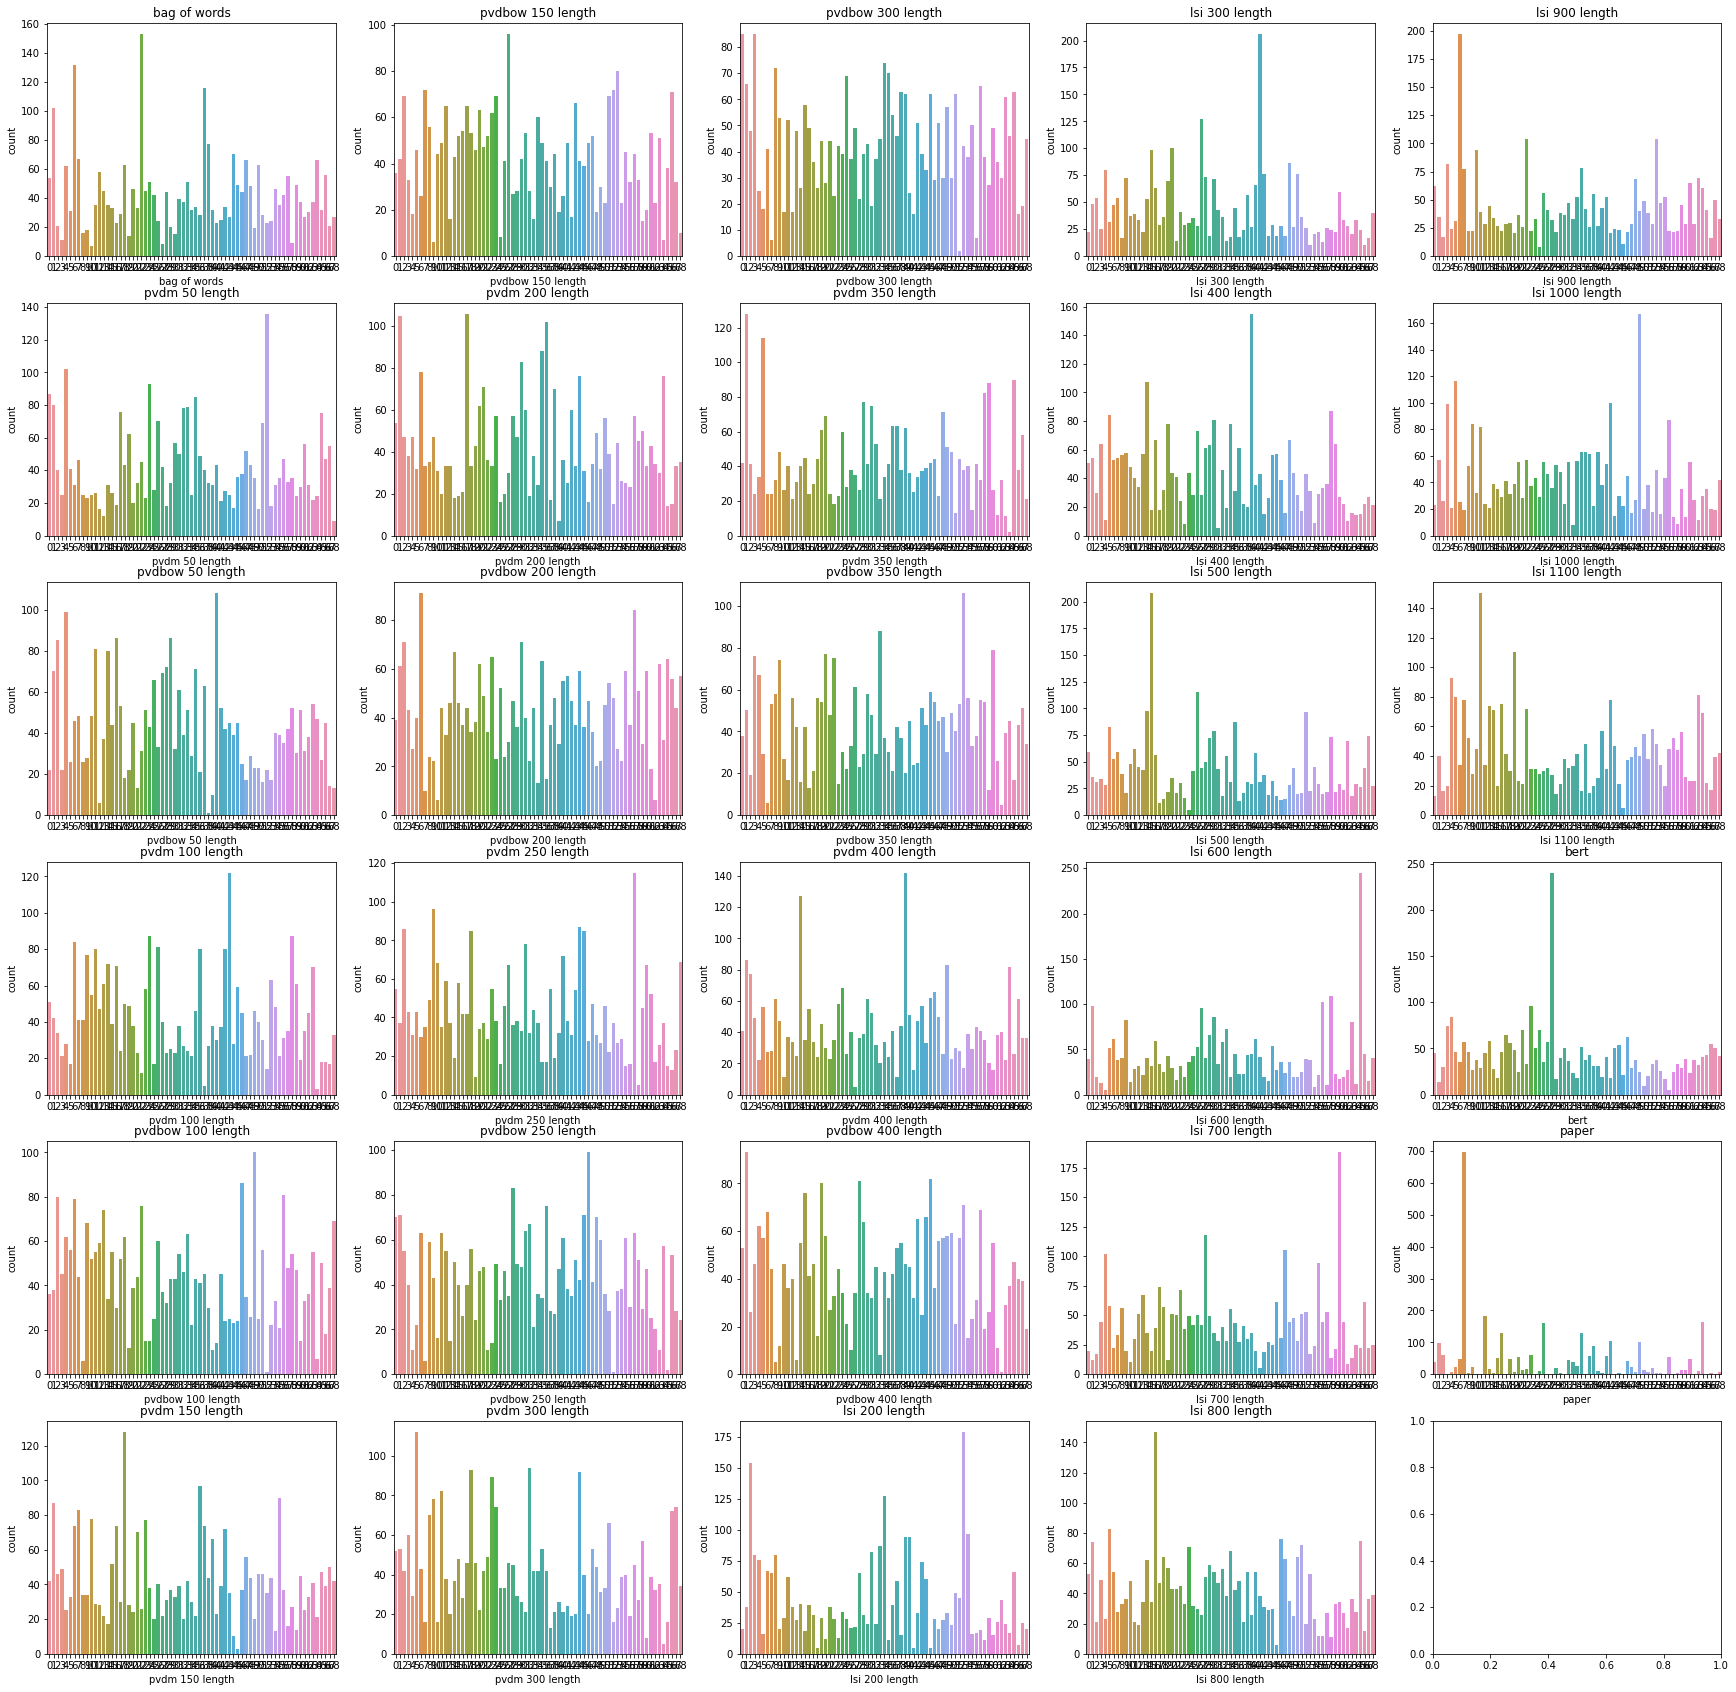

In [59]:
performance.plot_industry_dense()

In [64]:
ratio_df = pd.read_csv(PATH+'russell3000_ratios.csv')
def multiplier(num):
    out=np.nan
    if num[-1]=='B':
        out=float(num[:-1])*1000
    elif num[-1]=='T':
        out=float(num[:-1])*1000*1000
    elif num[-1]=='M':
        out=float(num[:-1])
    return out
ratio_df['mkt_cap']=ratio_df['mkt_cap'].map(multiplier)
ratio_df['beta'] = pd.to_numeric(ratio_df['beta'],errors='coerce')
ratio_df['profit_m']=ratio_df['profit_m'].map(lambda x: float(x.strip('%').replace(',',''))/100 if not pd.isnull(x) else np.nan)
ratio_df['roa']=ratio_df['roa'].map(lambda x: float(x.strip('%').replace(',',''))/100 if not pd.isnull(x) else np.nan)
ratio_df['roe']=ratio_df['roe'].map(lambda x: float(x.strip('%').replace(',',''))/100 if not pd.isnull(x) else np.nan)
charic_names=list(ratio_df.columns[2:])
ratio_df.dropna(inplace=True)

In [65]:
ratio_df = ratio_df[(np.abs(stats.zscore(ratio_df.iloc[:,1:]))<3).all(axis=1)]

In [66]:
cluster_names=list(all_cluster.columns[1:])
all_df=all_cluster.merge(ratio_df,how='inner',on='company')

In [67]:
eval_df=pd.DataFrame(columns=['clustering']+charic_names)
total_comp=all_df.shape[0]
charic_total=[]
for r in range(len(charic_names)):
    charic_total.append(ratio_df['mkt_cap'].dot(ratio_df.iloc[:,r+2]))
charic_total=charic_total/ratio_df['mkt_cap'].sum()
cl_results=[]
for cl in range(len(cluster_names)):
    cl_res=[cluster_names[cl]]
    for r in range(len(charic_names)):
        clr_df=all_df.loc[:,[cluster_names[cl],charic_names[r],'mkt_cap']]
        clr_df['sumpro']=clr_df[charic_names[r]]*clr_df['mkt_cap']
        clr_df=clr_df.groupby(cluster_names[cl]).agg({charic_names[r]:'count','mkt_cap':'sum','sumpro':'sum'})
        clr_df['sigma']=clr_df[charic_names[r]]/np.sum(clr_df[charic_names[r]])*(clr_df['sumpro']/clr_df['mkt_cap']-charic_total[r])**2
        clr=np.sqrt(clr_df['sigma'].sum())
        cl_res.append(clr)
    cl_results.append(cl_res)
eval_df=eval_df.append(pd.DataFrame(cl_results,columns=eval_df.columns))
eval_df['average']=eval_df.mean(1)
eval_df.set_index('clustering',inplace=True)
eval_df=eval_df.sort_values('average', ascending=False)
print('Market value weighted:')
print(eval_df)

Market value weighted:
                   pb_ratio      beta  profit_m       roa       roe   average
clustering                                                                   
lsi 400 length     6.074824  0.293554  0.133091  0.037944  0.240922  1.356067
bert               5.391137  0.321603  0.143406  0.040771  0.238956  1.227175
pvdbow 300 length  5.562382  0.226415  0.102840  0.028094  0.208231  1.225592
pvdbow 50 length   5.454919  0.240906  0.091981  0.037837  0.222806  1.209690
pvdbow 150 length  5.356219  0.225085  0.103968  0.033877  0.216937  1.187217
pvdbow 200 length  5.309278  0.218115  0.083237  0.028327  0.212864  1.170364
bag of words       5.169100  0.292225  0.115521  0.036041  0.217901  1.166158
lsi 200 length     5.021954  0.287884  0.147857  0.036999  0.220759  1.143090
pvdbow 400 length  5.147633  0.214683  0.099694  0.035707  0.209711  1.141485
lsi 900 length     4.894530  0.272902  0.118265  0.033719  0.205542  1.104992
lsi 700 length     4.832153  0.284604  0.

In [68]:
eval_df=pd.DataFrame(columns=['clustering']+charic_names)
total_comp=all_df.shape[0]
charic_total=[]
for r in range(len(charic_names)):
    charic_total.append(ratio_df.iloc[:,r+2].mean())
cl_results=[]
for cl in range(len(cluster_names)):
    cl_res=[cluster_names[cl]]
    for r in range(len(charic_names)):
        clr_df=all_df.loc[:,[cluster_names[cl],charic_names[r]]]
        clr_df=clr_df.groupby(cluster_names[cl]).agg(['count','mean'])
        clr_df=clr_df[clr_df[(charic_names[r],'count')]>=5]
        clr_df['sigma']=clr_df[(charic_names[r],'count')]/np.sum(clr_df[(charic_names[r],'count')])*(clr_df[(charic_names[r],'mean')]-charic_total[r])**2
        clr=np.sqrt(clr_df['sigma'].sum())
        cl_res.append(clr)
    cl_results.append(cl_res)
eval_df=eval_df.append(pd.DataFrame(cl_results,columns=eval_df.columns))
eval_df['average']=eval_df.mean(1)
eval_df.set_index('clustering',inplace=True)
eval_df=eval_df.sort_index()
#eval_df=eval_df.sort_values('average', ascending=False)
print('Equal value weighted:')
print(eval_df)

Equal value weighted:
                   pb_ratio      beta  profit_m       roa       roe   average
clustering                                                                   
bag of words       2.087717  0.308403  0.152806  0.044194  0.150064  0.548637
bert               1.868107  0.313593  0.156289  0.045786  0.149020  0.506559
lsi 1000 length    1.967517  0.302342  0.152407  0.044115  0.144852  0.522247
lsi 1100 length    2.017091  0.306724  0.156779  0.044723  0.153301  0.535724
lsi 200 length     1.894777  0.306009  0.153608  0.045143  0.146066  0.509121
lsi 300 length     2.056211  0.308146  0.157498  0.045058  0.151633  0.543709
lsi 400 length     2.069416  0.306732  0.155054  0.044705  0.158482  0.546878
lsi 500 length     1.928419  0.298474  0.157285  0.045903  0.158836  0.517783
lsi 600 length     1.995783  0.296805  0.152089  0.044033  0.135991  0.524940
lsi 700 length     1.983041  0.302486  0.150719  0.042387  0.131893  0.522105
lsi 800 length     2.035509  0.304123  0.1